In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import json
import keras
import keras.backend as K
# from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.models.resnet import resnet_retinanet as retinanet, custom_objects, download_imagenet
# import keras_retinanet
import keras_retinanet.bin.train
from sklearn.utils import shuffle 
import sklearn.model_selection

Using TensorFlow backend.


# data preparation

In [2]:
train_data = pd.read_json('../train_data_simple.json')
train_data = train_data.sort_index()
retinanet_data = pd.read_json('retinanet_data.json')
retinanet_data = retinanet_data.sort_index()

In [3]:
train_data.shape,retinanet_data.shape

((26561, 7), (26561, 8))

In [4]:
train_data.head(2)

,action_no,human_bbox,name,obj_id,obj_list,object_bbox,size
0,"[153, 154, 155, 156]","[209, 434, 28, 320]",HICO_train2015_00000001.jpg,[3],[motorcycle],"[64, 576, 103, 399]","[640, 480, 3]"
1,[224],"[262, 638, 1, 138]",HICO_train2015_00000002.jpg,[46],[banana],"[162, 258, 131, 165]","[640, 480, 3]"


In [5]:
retinanet_data.head()

,human_boxes,human_boxes_scale,human_classes,human_scores,obj_boxes,obj_boxes_scale,obj_classes,obj_scores
0,"[[408.5285644531, 137.1702575684, 590.03033447...","[[217, 82, 314, 289], [189, 108, 388, 279], [2...","[0, 0, 0, 0]","[0.24128636720000002, 0.2087177634, 0.35492742...","[[384.8578491211, 70.9428253174, 883.437683105...","[[205, 42, 471, 217], [217, 82, 314, 289], [16...","[3, 0, 3, 3, 3, 0, 0, 0, 3]","[0.2452710122, 0.24128636720000002, 0.49595344..."
1,"[[515.2573242188, 2.3874969482, 1107.571899414...","[[274, 1, 590, 126], [401, 0, 636, 140]]","[0, 0]","[0.34479168060000004, 0.6770228148]","[[756.3471679688, 567.7899169922, 817.62744140...","[[403, 340, 436, 363], [405, 341, 436, 363], [...","[49, 51, 51, 39, 41, 39, 55, 53, 45, 41, 45, 7...","[0.2125296295, 0.235072419, 0.2925423980000000..."
2,[],"[[274, 401], [1, 0], [590, 636], [126, 140]]",[],[],"[[295.9039916992, 352.1661376953, 341.69757080...","[[147, 281, 170, 341], [0, 361, 15, 388], [0, ...","[9, 2, 2, 2, 2, 2, 2, 2, 2, 7, 5, 5, 5]","[0.45125731830000004, 0.2788699865, 0.64107280..."
3,"[[939.8218383789, 401.7608642578, 984.80657958...","[[501, 214, 525, 277], [130, 203, 165, 311], [...","[0, 0, 0, 0, 0, 0]","[0.6018131971, 0.2301999032, 0.3746683598, 0.9...","[[939.8218383789, 401.7608642578, 984.80657958...","[[501, 214, 525, 277], [130, 203, 165, 311], [...","[0, 0, 27, 0, 0, 0, 0]","[0.6018131971, 0.2301999032, 0.2251143306, 0.3..."
4,"[[192.0525970459, 291.7764892578, 370.51116943...","[[102, 155, 197, 265]]",[0],[0.9221789241],"[[321.814666748, 445.8058776855, 350.372467041...","[[171, 236, 186, 261], [532, 275, 554, 292], [...","[41, 67, 39, 0, 62, 59, 60, 60, 13, 60, 59]","[0.21376061440000002, 0.2884043753, 0.73071849..."


In [6]:
action_list = []
image_name = []
for id_ in range(len(train_data)):
    image_name.append(os.path.join('/home/jovyan/projectdata/cht01/hico_20160224_det/images/train2015/',train_data['name'][id_]))
    action_array = np.zeros(600)
    for i in train_data.action_no[id_]:
        action_array[i-1]=1
    action_list.append(action_array)
action_list = np.array(action_list)
image_name = np.array(image_name)

In [7]:
human_gt = [[item[0],item[2],item[1],item[3]] for item in train_data.human_bbox.tolist()]
human_gt = np.array(human_gt)
object_gt = [[item[0],item[2],item[1],item[3]] for item in train_data.object_bbox.tolist()]
object_gt = np.array(object_gt)
obj_label_gt = train_data.obj_id.as_matrix()

In [8]:
#img_input,obj_boxes,obj_classes,human_boxes
obj_boxes,obj_boxes_scale,human_boxes,human_boxes_scale,obj_classes=[],[],[],[],[]
for id_ in range(len(train_data)):
    obj_box = retinanet_data.obj_boxes[id_]
    obj_box_scale = retinanet_data.obj_boxes_scale[id_]
    obj_class = retinanet_data.obj_classes[id_]
    human_box = retinanet_data.human_boxes[id_]
    human_box_scale = retinanet_data.human_boxes_scale[id_]

    obj_box = np.array(obj_box)
    obj_box_scale = np.array(obj_box_scale)
    obj_class = np.array(obj_class)
    human_box = np.array(human_box)
    human_box_scale = np.array(human_box_scale)
    
    obj_boxes.append(obj_box)
    obj_boxes_scale.append(obj_box_scale)
    obj_classes.append(obj_class)
    human_boxes.append(human_box)
    human_boxes_scale.append(human_box_scale)
    
obj_boxes = np.array(obj_boxes)
obj_boxes_scale = np.array(obj_boxes_scale)
obj_classes = np.array(obj_classes)
human_boxes = np.array(human_boxes)
human_boxes_scale = np.array(human_boxes_scale)

In [9]:
image_name_train,image_name_val = sklearn.model_selection.train_test_split(image_name,test_size=0.05,random_state=42)

human_boxes_train,human_boxes_val = sklearn.model_selection.train_test_split(human_boxes,test_size=0.05,random_state=42)

human_boxes_scale_train,human_boxes_scale_val = sklearn.model_selection.train_test_split(human_boxes_scale,test_size=0.05,random_state=42)

obj_boxes_train,obj_boxes_val = sklearn.model_selection.train_test_split(obj_boxes,test_size=0.05,random_state=42)

obj_boxes_scale_train,obj_boxes_scale_val = sklearn.model_selection.train_test_split(obj_boxes_scale,test_size=0.05,random_state=42)

obj_classes_train,obj_classes_val = sklearn.model_selection.train_test_split(obj_classes,test_size=0.05,random_state=42)

action_list_train,action_list_val = sklearn.model_selection.train_test_split(action_list,test_size=0.05,random_state=42)

human_gt_train,human_gt_val = sklearn.model_selection.train_test_split(human_gt,test_size=0.05,random_state=42)

object_gt_train,object_gt_val = sklearn.model_selection.train_test_split(object_gt,test_size=0.05,random_state=42)

obj_label_gt_train,obj_label_gt_val = sklearn.model_selection.train_test_split(obj_label_gt,test_size=0.05,random_state=42)

In [10]:
x_train = [image_name_train,human_boxes_train,human_boxes_scale_train,obj_boxes_train,obj_boxes_scale_train,obj_classes_train]

x_val = [image_name_val,human_boxes_val,human_boxes_scale_val,obj_boxes_val,obj_boxes_scale_val,obj_classes_val]

y_train = [action_list_train,human_gt_train,object_gt_train,obj_label_gt_train]

y_val = [action_list_val,human_gt_val,object_gt_val,obj_label_gt_val]

# define model

In [11]:
def human_stream(ip):
    ho_pair = ip[0]
    human_boxes = ho_pair[:,:,0,:]
    img_input = ip[1]
    i = K.tf.constant(0)
    batch_count = K.tf.shape(human_boxes)[0]
    result = K.tf.TensorArray(dtype=K.tf.float32, size=batch_count)
    human_boxes_norm = K.tf.TensorArray(dtype=K.tf.float32, size=batch_count)
    
    def condition(i,result,human_boxes_norm):
        return i < batch_count    
    def body(i,result,human_boxes_norm):
        crop_size = K.tf.constant([200,200])
        batch_inds = K.tf.zeros((K.tf.shape(human_boxes[i])[0],), dtype=K.tf.int32) 
        one_human_boxes_norm = human_boxes[i]/[1200,800,1200,800]
        one_human_boxes_norm = K.tf.stack([one_human_boxes_norm[:,1],one_human_boxes_norm[:,0],one_human_boxes_norm[:,3],one_human_boxes_norm[:,2]],axis=1)
        one_image = K.tf.image.crop_and_resize(K.expand_dims(img_input[i],axis=0),one_human_boxes_norm,batch_inds,crop_size)
        one_image = (one_image-K.min(one_image))/255 
        result = result.write(i, one_image)
        human_boxes_norm = human_boxes_norm.write(i,one_human_boxes_norm)
        i = K.tf.add(i,1)
        return [i,result,human_boxes_norm]    
    
    _,result, human_boxes_norm = K.tf.while_loop(condition, body, [i, result,human_boxes_norm])
    result_stack = result.stack()
    human_boxes_norm_stack = human_boxes_norm.stack()
    return [result_stack,human_boxes_norm_stack]
    
def obj_stream(ip):
    ho_pair = ip[0]
    obj_boxes = ho_pair[:,:,1,:]
    img_input = ip[1]
    i = K.tf.constant(0)
    batch_count = K.tf.shape(obj_boxes)[0]
    result = K.tf.TensorArray(dtype=K.tf.float32, size=batch_count)
    obj_boxes_norm = K.tf.TensorArray(dtype=K.tf.float32, size=batch_count)
    
    def condition(i,result,obj_boxes_norm):
        return i < batch_count    
    def body(i,result,obj_boxes_norm):
        crop_size = K.tf.constant([200,200])
        batch_inds = K.tf.zeros((K.tf.shape(obj_boxes[i])[0],), dtype=K.tf.int32) 
        one_obj_boxes_norm = obj_boxes[i]/[1200,800,1200,800]
        one_obj_boxes_norm = K.tf.stack([one_obj_boxes_norm[:,1],one_obj_boxes_norm[:,0],one_obj_boxes_norm[:,3],one_obj_boxes_norm[:,2]],axis=1)
        one_image = K.tf.image.crop_and_resize(K.expand_dims(img_input[i],axis=0),one_obj_boxes_norm,batch_inds,crop_size)
        one_image = (one_image-K.min(one_image))/255 
        result = result.write(i, one_image)
        obj_boxes_norm = obj_boxes_norm.write(i,one_obj_boxes_norm)
        i = K.tf.add(i,1)
        return [i,result,obj_boxes_norm]    
    
    _,result, obj_boxes_norm = K.tf.while_loop(condition, body, [i, result,obj_boxes_norm])
    result_stack = result.stack()
    obj_boxes_norm_stack = obj_boxes_norm.stack()
    return [result_stack,obj_boxes_norm_stack]

def human_object_pair(ip):
    human_boxes=ip[0]
    obj_boxes=ip[1]
    i = K.tf.constant(0)
    batch_count = K.tf.shape(obj_boxes)[0]
    ho_pair = K.tf.TensorArray(dtype=K.tf.float32, size=batch_count)
    
    def condition(i,ho_pair):
        return i < batch_count    
    def body(i,ho_pair):
        human_count =K.tf.shape(human_boxes[i])[0]
        obj_count = K.tf.shape(obj_boxes[i])[0]
        ho_pair_one=[]
        xx = K.tf.expand_dims(human_boxes[i], -1)
        xx = K.tf.tile(xx, K.tf.stack([1, 1, obj_count]))
        yy = K.tf.expand_dims(obj_boxes[i], -1)
        yy = K.tf.tile(yy, K.tf.stack([1, 1, human_count]))
        yy = K.tf.transpose(yy, perm=[2, 1, 0])       
        ho_pair_one = K.tf.stack([xx,yy],axis=1)
        ho_pair_one = K.tf.transpose(ho_pair_one,perm=[0,3,1,2])
        ho_pair_one = K.tf.reshape(ho_pair_one,shape=(-1,2,4))
        ho_pair = ho_pair.write(i, ho_pair_one)
        i = K.tf.add(i,1)
        return [i,ho_pair]    
    
    _,ho_pair = K.tf.while_loop(condition, body, [i, ho_pair])
    ho_pair_stack = ho_pair.stack()
    return ho_pair_stack

def attention_pattern(ho_pair):
    
    outer_i = K.tf.constant(0)
    batch_count = K.tf.shape(ho_pair)[0]
    all_image_pair_mask = K.tf.TensorArray(dtype=K.tf.float32, size=batch_count)


    def outer_condition(i,all_image_pair_mask):
        return i < batch_count
    def outer_body(outer_i,all_image_pair_mask):
        pair_count = K.tf.shape(ho_pair[outer_i])[0]
        offset_height_h = K.tf.cast(ho_pair[outer_i,:,0,1],K.tf.int32)
        offset_width_h = K.tf.cast(ho_pair[outer_i,:,0,0],K.tf.int32)
        target_height_h = K.tf.cast(ho_pair[outer_i,:,0,3],K.tf.int32) - offset_height_h 
        target_width_h = K.tf.cast(ho_pair[outer_i,:,0,2],K.tf.int32) - offset_width_h
        offset_height_o = K.tf.cast(ho_pair[outer_i,:,1,1],K.tf.int32)
        offset_width_o = K.tf.cast(ho_pair[outer_i,:,1,0],K.tf.int32)
        target_height_o = K.tf.cast(ho_pair[outer_i,:,1,3],K.tf.int32) - offset_height_o
        target_width_o = K.tf.cast(ho_pair[outer_i,:,1,2],K.tf.int32) -offset_width_o
        mask_base = K.tf.constant(1,shape=(800,1200,3),dtype=K.tf.float32)
        inner_i = K.tf.constant(0)
        one_image_pair_mask = K.tf.TensorArray(dtype=K.tf.float32, size=pair_count)
        
        def inner_condition(inner_i, outer_i,one_image_pair_mask):
            return inner_i < pair_count
    
        def inner_body(inner_i, outer_i,one_image_pair_mask):
        
            top_bound = K.tf.reduce_min(K.tf.stack([offset_height_h[inner_i],offset_height_o[inner_i]]))
            left_bound = K.tf.reduce_min(K.tf.stack([offset_width_h[inner_i],offset_width_o[inner_i]]))
            bottom_bound = K.tf.reduce_max(K.tf.stack([offset_height_h[inner_i]+target_height_h[inner_i],offset_height_o[inner_i]+target_height_o[inner_i]]))
            right_bound = K.tf.reduce_max(K.tf.stack([offset_width_h[inner_i]+target_width_h[inner_i],offset_width_o[inner_i]+target_width_o[inner_i]]))
            mask_target_height = bottom_bound-top_bound
            mask_target_width = right_bound-left_bound
            mask_h = K.tf.image.crop_to_bounding_box(
                mask_base,offset_height_h[inner_i],offset_width_h[inner_i],target_height_h[inner_i],target_width_h[inner_i])
            mask_h = K.tf.image.pad_to_bounding_box(mask_h,offset_height_h[inner_i]-top_bound,offset_width_h[inner_i]-left_bound,mask_target_height,mask_target_width)
            mask_h = K.tf.image.resize_image_with_crop_or_pad(mask_h,K.tf.shape(mask_base)[0],K.tf.shape(mask_base)[1])
            mask_o = K.tf.image.crop_to_bounding_box(
                mask_base,offset_height_o[inner_i],offset_width_o[inner_i],target_height_o[inner_i],target_width_o[inner_i])
            mask_o = K.tf.image.pad_to_bounding_box(mask_o,offset_height_o[inner_i]-top_bound,offset_width_o[inner_i]-left_bound,mask_target_height,mask_target_width)
            mask_o = K.tf.image.resize_image_with_crop_or_pad(mask_o,K.tf.shape(mask_base)[0],K.tf.shape(mask_base)[1])
            mask_combine = [K.tf.reduce_mean(mask_h,axis=2),K.tf.reduce_mean(mask_o,axis=2),K.tf.constant(0,shape=(800,1200),dtype=K.tf.float32)]
            mask_combine = K.tf.stack(mask_combine,axis =2)
            mask_combine = K.tf.expand_dims(mask_combine,axis=0)
            mask_combine = K.tf.image.resize_bilinear(mask_combine,[128,128])
            mask_combine = K.tf.squeeze(mask_combine,axis=0)
            one_image_pair_mask = one_image_pair_mask.write(inner_i, mask_combine)
            inner_i = K.tf.add(inner_i,1)
            return [inner_i,outer_i, one_image_pair_mask]  
    
        _,_,one_image_pair_mask= K.tf.while_loop(inner_condition, inner_body, [inner_i, outer_i,one_image_pair_mask])
        one_image_pair_mask_stack = one_image_pair_mask.stack()
        all_image_pair_mask = all_image_pair_mask.write(outer_i, one_image_pair_mask_stack)
        outer_i = K.tf.add(outer_i,1)
        return [outer_i, all_image_pair_mask] 
    
    _,all_image_pair_mask = K.tf.while_loop(outer_condition, outer_body, [outer_i, all_image_pair_mask])
    all_image_pair_mask_stack = all_image_pair_mask.stack()        

    return all_image_pair_mask_stack

In [13]:
human_boxes

<tf.Tensor 'input_4:0' shape=(?, ?, 4) dtype=float32>

In [12]:
img_input = keras.layers.Input(shape=(800,1200,3))
obj_boxes = keras.layers.Input(shape=(None,4))
obj_classes = keras.layers.Input(shape=(None,))
human_boxes = keras.layers.Input(shape=(None,4))

# ho_pair= keras.layers.Lambda(human_object_pair)([human_boxes,obj_boxes])

# human_subimage,human_boxes_norm = keras.layers.Lambda(human_stream)([ho_pair,img_input])

# obj_subimage,obj_boxes_norm = keras.layers.Lambda(obj_stream)([ho_pair,img_input])

# pair_mask_stack = keras.layers.Lambda(attention_pattern)(ho_pair)

In [40]:
def expand_dim(ip):
    human_subimage = ip[0]
    object_subimage = ip[1]
    pair_mask_stack = ip[2]
    human_subimage_expand = K.tf.expand_dims(human_subimage,axis=0)
    obj_subimage_expand = K.tf.expand_dims(obj_subimage,axis=0)
    pair_mask_stack_expand = K.tf.expand_dims(pair_mask_stack,axis=0)
    return [human_subimage_expand,obj_subimage_expand,pair_mask_stack_expand]
def output_sum(score_600):
    score_sum = K.tf.reduce_sum(score_600,axis=1)
    return score_sum

In [41]:
#human stream
h_conv1 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(human_subimage)
h_pool1 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(3,3)))(h_conv1)
h_conv2 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(h_pool1)
h_pool2 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(3,3)))(h_conv2)
h_conv3 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(h_pool2)
h_pool3 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(3,3)))(h_conv3)
h_flat = keras.layers.TimeDistributed(keras.layers.Flatten())(h_pool3)
h_output = keras.layers.TimeDistributed(keras.layers.Dense(units=600,activation='relu'))(h_flat)
#object stream
o_conv1 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(obj_subimage)
o_pool1 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(3,3)))(o_conv1)
o_conv2 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(o_pool1)
o_pool2 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(3,3)))(o_conv2)
o_conv3 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(o_pool2)
o_pool3 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(3,3)))(o_conv3)
o_flat = keras.layers.TimeDistributed(keras.layers.Flatten())(o_pool3)
o_output = keras.layers.TimeDistributed(keras.layers.Dense(units=600,activation='relu'))(o_flat)
#pairwise stream
p_conv1 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(pair_mask_stack)
p_pool1 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(2,2)))(p_conv1)
p_conv2 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(p_pool1)
p_pool2 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(2,2)))(p_conv2)
p_conv3 = keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1), padding='same',activation='relu'))(p_pool2)
p_pool3 = keras.layers.TimeDistributed(keras.layers.MaxPool2D(pool_size=(2,2)))(p_conv3)
p_flat = keras.layers.TimeDistributed(keras.layers.Flatten())(p_pool3)
p_output = keras.layers.TimeDistributed(keras.layers.Dense(units=600,activation='relu'))(p_flat)



# score_sum = keras.layers.Add()([h_output_merge,o_output_merge,p_output_merge])
# score_sum_sigmoid = keras.layers.Dense(600,activation='sigmoid')(score_sum)
score_sum = keras.layers.Add()([h_output,o_output,p_output])
score_sum_sigmoid = keras.layers.Dense(600,activation='sigmoid')(score_sum)
obj_classes_output = keras.layers.Activation('relu')(obj_classes)

In [42]:
model = keras.Model(inputs=[img_input,human_boxes,obj_boxes,obj_classes],outputs=[score_sum_sigmoid,obj_classes_output])

In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, 2, 4)   0           input_8[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 800, 1200, 3) 0                                            
__________

In [17]:
# def custom_loss(y_true, y_pred):
#     y_true = y_true[0]
#     y_pred = y_pred[0]
#     return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

# def binary_accuracy(y_true, y_pred):
#     y_true = y_true[0]
#     y_pred = y_pred[0]
#     return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

In [18]:
opt = keras.optimizers.Adam()

model.compile(loss='binary_crossentropy',
              optimizer=opt,loss_weights=[1,0])
earlystop = keras.callbacks.EarlyStopping(monitor='val_dense_4_loss',patience=2)

# data generator

In [19]:
# x_train = [image_name,human_boxes,obj_boxes,obj_classes]  y_label = [action_list,human_gt,object_gt]
# (x1, y1, x2, y2)
def bb_intersection_over_union(boxA,boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = (xB - xA + 1) * (yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [20]:
# x_train = [image_name_train, human_boxes_train, human_boxes_scale_train, obj_boxes_train, obj_boxes_scale_train, obj_classes_train]
# x_val = [image_name_val,human_boxes_val,human_boxes_scale_val,obj_boxes_val,obj_boxes_scale_val,obj_classes_val]
# y_train = [action_list_train, human_gt_train, object_gt_train, obj_label_gt_train]
# y_val = [action_list_val,human_gt_val,object_gt_val,obj_label_gt_val]
def data_gen(x_train, y_label,batch_size=8):
    img_stack = np.array([]).reshape(0,800,1200,3)
    action_array_stack = np.array([]).reshape(0,1,600)
    human_stack = np.array([]).reshape(0,1,4)
    object_stack = np.array([]).reshape(0,1,4)
    object_class_stack = np.array([]).reshape(0,1)
    while True:
        new_ind = shuffle(range(len(x_train[0])))
        for i in new_ind:
            if (x_train[1][i].any()) & (x_train[3][i].any()) &(y_label[3][i][0] in x_train[5][i]):
                
                human_iou_list = []
                for k in x_train[2][i]:
                    human_iou_list.append(bb_intersection_over_union(y_label[1][i],k))
                object_iou_list = []
                for j in x_train[4][i]:
                    object_iou_list.append(bb_intersection_over_union(y_label[1][i],j))
                
                ho_pair_h = x_train[1][i][np.argmax(human_iou_list)]
                ho_pair_o = x_train[3][i][np.argmax((x_train[5][i]==y_label[3][i][0])*object_iou_list)]
                ho_pair_h = np.expand_dims(ho_pair_h,axis=0)
                ho_pair_h = np.expand_dims(ho_pair_h,axis=0)
                ho_pair_o = np.expand_dims(ho_pair_o,axis=0)
                ho_pair_o = np.expand_dims(ho_pair_o,axis=0)

                object_class = x_train[5][i][np.argmax((x_train[5][i]==y_label[3][i][0])*object_iou_list)]
                object_class = np.expand_dims(object_class,axis=0)
                object_class = np.expand_dims(object_class,axis=0)

                
                img = cv2.imread(x_train[0][i])[:,:,::-1]
                img = cv2.resize(img, (1200,800))
                img = img/255
                img = np.expand_dims(img,axis=0)
                
                action_array = y_label[0][i]
                action_array = np.expand_dims(action_array,axis=0)
                action_array = np.expand_dims(action_array,axis=0)


                img_stack = np.row_stack([img_stack,img])
                action_array_stack = np.row_stack([action_array_stack,action_array])
                human_stack = np.row_stack([human_stack,ho_pair_h])
                object_stack = np.row_stack([object_stack,ho_pair_o])
                object_class_stack = np.row_stack([object_class_stack,object_class])
                
                if img_stack.shape[0]==batch_size:
                    x_batch = [img_stack,human_stack,object_stack,object_class_stack]
                    y_batch = [action_array_stack,object_class_stack]
                    img_stack = np.array([]).reshape(0,800,1200,3)
                    action_array_stack = np.array([]).reshape(0,1,600)
                    human_stack = np.array([]).reshape(0,1,4)
                    object_stack = np.array([]).reshape(0,1,4)
                    object_class_stack = np.array([]).reshape(0,1)
                    yield x_batch, y_batch

In [30]:
batch=8
train_gen = data_gen(x_train,y_train,batch)
val_gen = data_gen(x_val,y_val,batch)

In [31]:
len(x_train[0]),len(x_val[0])

(25232, 1329)

In [137]:
# a,b = next(train_gen)
# a[0].shape,a[1].shape,a[2].shape,a[3].shape,b[0].shape,b[1].shape

# 爆Train一發

In [68]:
# #multiGPU在lamdba layer會有問題
# model_multi = keras.utils.multi_gpu_model(model,gpus=2)
# opt = keras.optimizers.Adam()

# model_multi.compile(loss='binary_crossentropy',
#               optimizer=opt,loss_weights=[1,0])

In [160]:
model.fit_generator(train_gen,steps_per_epoch=int(25232/batch),epochs=100,
                    validation_data=val_gen,validation_steps=int(1329/batch),callbacks=[earlystop])
# model.fit_generator(train_gen,steps_per_epoch=10,epochs=2,validation_data=val_gen,validation_steps=2)
# model_multi.fit_generator(train_gen,steps_per_epoch=30,epochs=10,validation_data=val_gen,validation_steps=2)


Epoch 1/100
 583/3154 [====>.........................] - ETA: 33:34 - loss: 0.0111 - dense_4_loss: 0.0111 - activation_1_loss: -386.4730

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


3154/3154 [==============================] - 2958s 938ms/step - loss: 0.0099 - dense_4_loss: 0.0099 - activation_1_loss: -397.6024 - val_loss: 0.0161 - val_dense_4_loss: 0.0161 - val_activation_1_loss: -397.1311
Epoch 2/100
3154/3154 [==============================] - 6874s 2s/step - loss: 0.0059 - dense_4_loss: 0.0059 - activation_1_loss: -399.7355 - val_loss: 0.0197 - val_dense_4_loss: 0.0197 - val_activation_1_loss: -401.6809
Epoch 3/100
3154/3154 [==============================] - 1840s 584ms/step - loss: 0.0031 - dense_4_loss: 0.0031 - activation_1_loss: -399.3437 - val_loss: 0.0265 - val_dense_4_loss: 0.0265 - val_activation_1_loss: -395.2703


In [45]:
model_json = model.to_json()
with open("/home/jovyan/hico_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('/home/jovyan/hico_second_try.h5')


# check training result

In [46]:
json_file = open('/home/jovyan/hico_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(model_json)
model.load_weights('/home/jovyan/hico_second_try.h5')

In [22]:
with open('../hoi_dict.json', 'r') as f:
    hoi_dict = json.load(f)
visualize_gen = data_gen(x_train,y_train,batch_size=1)

pred_id&score:  [[467, 0.85836297], [470, 0.80333132], [472, 0.84393972]]
pred_hoi:  [['inspect', 'skis'], ['repair', 'skis'], ['stand_on', 'skis']]
gt_id:  [467, 470, 472]
gt_hoi:  [['inspect', 'skis'], ['repair', 'skis'], ['stand_on', 'skis']]


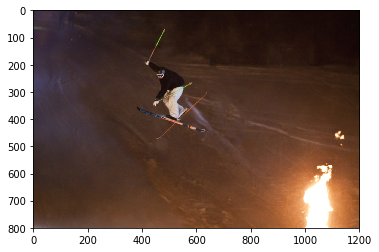

In [34]:
a,b= next(visualize_gen)
pred = model.predict_on_batch(a)
pred_id=[index for index, value in enumerate((pred[0][0][0]>0.4).tolist()) if value == 1]
gt_id=[index for index, value in enumerate(b[0][0][0].tolist()) if value == 1]
print('pred_id&score: ',[[item,pred[0][0][0][item]] for item in pred_id])
print('pred_hoi: ',[hoi_dict[str(item)] for item in pred_id])
print('gt_id: ',gt_id)
print('gt_hoi: ',[hoi_dict[str(item)] for item in gt_id])
plt.imshow(a[0][0])